# Pyruvate Kinase (PYK)

Based on “Network-Level Allosteric Effects Are Elucidated by Detailing How Ligand-Binding Events Modulate Utilization of Catalytic Potentials."

__URL:__ https://doi.org/10.1371/journal.pcbi.1006356

For the construction of the PFK `EnzymeModule`, the following assumptions were made:

1. The enzyme is a homotetramer.
2. The enzyme binding and catalyzation of substrates occurs in a random sequential mechanism.
3. The mechanism of allosteric regulation is based on the Monod-Wyman-Changeux (MWC) model for allosteric transitions of homoproteins.

\\(\text{[PYK]}_{total} = 69 nM = 0.069 \mu M = 0.000069 mM\\).

Based on “Network-Level Allosteric Effects Are Elucidated by Detailing How Ligand-Binding Events Modulate Utilization of Catalytic Potentials."

__URL:__ https://doi.org/10.1371/journal.pcbi.1006356

In [1]:
from operator import attrgetter
from os import path

from cobra import DictList

import matplotlib.pyplot as plt

from scipy import optimize

import sympy as sym

import mass
from mass import MassMetabolite, Simulation, UnitDefinition
from mass.enzyme_modules import EnzymeModule
from mass.io import json
from mass.util import Keq2k, k2Keq, strip_time, qcqa_model

print("MASSpy version: " + mass.__version__)

MASSpy version: 0.1.0


## Load Models

In [2]:
glycolysis = json.load_json_model(
    filename=path.realpath(path.join("CS1_data", "models", "Glycolysis.json")))

Using license file /Users/zhaiman/opt/licenses/gurobi.lic
Academic license - for non-commercial use only


## Module Construction

In [3]:
PYK = EnzymeModule("PYK", name="Pyruvate Kinase",
                   subsystem="Glycolysis")

### Metabolites
#### Ligands

In [4]:
pep_c = MassMetabolite(
    "pep_c",
    name="Phosphoenolpyruvate",
    formula="C3H2O6P",
    charge=-3,
    compartment="c")
pyr_c = MassMetabolite(
    "pyr_c",
    name="Pyruvate",
    formula="C3H3O3",
    charge=-1,
    compartment="c")
fdp_c = MassMetabolite(
    "fdp_c",
    name="D-Fructose 1,6-bisphosphate",
    formula="C6H10O12P2",
    charge=-4,
    compartment="c")
atp_c = MassMetabolite(
    "atp_c",
    name="ATP",
    formula="C10H12N5O13P3",
    charge=-4,
    compartment="c")
adp_c = MassMetabolite(
    "adp_c",
    name="ADP",
    formula="C10H12N5O10P2",
    charge=-3,
    compartment="c")
h_c = MassMetabolite(
    "h_c",
    name="H+",
    formula="H",
    charge=1,
    compartment="c")

PYK.add_metabolites([pep_c, adp_c, fdp_c, atp_c, pyr_c, h_c])

PYK.enzyme_module_ligands_categorized =  {
    "substrates": pep_c,
    "cofactors": [adp_c, h_c],
    "activators": [fdp_c],
    "inhibitors": atp_c,
    "products": [pyr_c, atp_c]}

# Access categorized attribute for ligands and print
for group in PYK.enzyme_module_ligands_categorized:
    print("{0}: {1}".format(
        group.id, str(sorted([m.id for m in group.members]))))

substrates: ['pep_c']
cofactors: ['adp_c', 'h_c']
activators: ['fdp_c']
inhibitors: ['atp_c']
products: ['atp_c', 'pyr_c']


#### EnzymeModuleForms

In [5]:
# Number of identical subunits
n_subunits = 4

for i in range(n_subunits + 1):
    # Make enzyme module forms per number of bound activators (Up to 4 Total)
    PYK.make_enzyme_module_form(
        "pyk_R{0:d}_c".format(i), 
        name="Automatic", 
        categories="Active", 
        bound_metabolites={fdp_c: i},
        compartment="c");

    PYK.make_enzyme_module_form(
        "pyk_R{0:d}_A_c".format(i), 
        name="Automatic", 
        categories="Active", 
        bound_metabolites={adp_c: 1, fdp_c: i},
        compartment="c");
    
    PYK.make_enzyme_module_form(
        "pyk_R{0:d}_P_c".format(i), 
        name="Automatic", 
        categories="Active", 
        bound_metabolites={pep_c: 1, fdp_c: i},
        compartment="c");
    
    PYK.make_enzyme_module_form(
        "pyk_R{0:d}_AP_c".format(i), 
        name="Automatic", 
        categories="Active", 
        bound_metabolites={adp_c: 1, pep_c: 1, fdp_c: i},
        compartment="c");

    # Make enzyme module forms per number of bound inhibitors (Up to 4 Total)
    PYK.make_enzyme_module_form(
        "pyk_T{0:d}_c".format(i), 
        name="Automatic", 
        categories="Inhibited", 
        bound_metabolites={atp_c: i},
        compartment="c");

# Access categorized attribute for enzyme module forms and print
for group in PYK.enzyme_module_forms_categorized:
    print("{0}: {1}\n".format(
        group.id, str(sorted([m.id for m in group.members]))))

Active: ['pyk_R0_AP_c', 'pyk_R0_A_c', 'pyk_R0_P_c', 'pyk_R0_c', 'pyk_R1_AP_c', 'pyk_R1_A_c', 'pyk_R1_P_c', 'pyk_R1_c', 'pyk_R2_AP_c', 'pyk_R2_A_c', 'pyk_R2_P_c', 'pyk_R2_c', 'pyk_R3_AP_c', 'pyk_R3_A_c', 'pyk_R3_P_c', 'pyk_R3_c', 'pyk_R4_AP_c', 'pyk_R4_A_c', 'pyk_R4_P_c', 'pyk_R4_c']

Inhibited: ['pyk_T0_c', 'pyk_T1_c', 'pyk_T2_c', 'pyk_T3_c', 'pyk_T4_c']



### Reactions
#### EnzymeModuleReactions

In [6]:
for i in range(n_subunits + 1):
    # Make reactions for enzyme-ligand binding and catalytzation per number of bound activators (Up to 4 Total)
    PYK.make_enzyme_module_reaction(
        "PYK_R{0:d}1".format(i), 
        name="Automatic",
        subsystem="Glycolysis",
        reversible=True,
        categories="pep_c_binding",
        metabolites_to_add={
            "pyk_R{0:d}_c".format(i): -1, 
            "pep_c": -1, 
            "pyk_R{0:d}_P_c".format(i): 1})
    
    PYK.make_enzyme_module_reaction(
        "PYK_R{0:d}2".format(i), 
        name="Automatic",
        subsystem="Glycolysis",
        reversible=True,
        categories="adp_c_binding",
        metabolites_to_add={
            "pyk_R{0:d}_c".format(i): -1, 
            "adp_c": -1, 
            "pyk_R{0:d}_A_c".format(i): 1})
    
    PYK.make_enzyme_module_reaction(
        "PYK_R{0:d}3".format(i), 
        name="Automatic",
        subsystem="Glycolysis",
        reversible=True,
        categories="pep_c_binding",
        metabolites_to_add={
            "pyk_R{0:d}_A_c".format(i): -1, 
            "pep_c": -1, 
            "pyk_R{0:d}_AP_c".format(i): 1})
    
    PYK.make_enzyme_module_reaction(
        "PYK_R{0:d}4".format(i), 
        name="Automatic",
        subsystem="Glycolysis",
        reversible=True,
        categories="adp_c_binding",
        metabolites_to_add={
            "pyk_R{0:d}_P_c".format(i): -1, 
            "adp_c": -1, 
            "pyk_R{0:d}_AP_c".format(i): 1})
    
    PYK.make_enzyme_module_reaction(
        "PYK_R{0:d}5".format(i), 
        name="Automatic",
        subsystem="Glycolysis",
        reversible=False,
        categories="catalyzation",
        metabolites_to_add={
            "pyk_R{0:d}_AP_c".format(i): -1, 
            "h_c": -1, 
            "pyk_R{0:d}_c".format(i): 1, 
            "atp_c": 1, 
            "pyr_c": 1})
    
    if i < n_subunits:
        # Make enzyme reactions for enzyme-activator binding
        PYK.make_enzyme_module_reaction(
            "PYK_R{0:d}0".format(i + 1), 
            name="Automatic",
            subsystem="Glycolysis",
            reversible=True,
            categories="fdp_c_activation",
            metabolites_to_add={
                "pyk_R{0:d}_c".format(i): -1, 
                "fdp_c": -1, 
                "pyk_R{0:d}_c".format(i + 1): 1})

        # Make enzyme reactions for enzyme-inhibitor binding
        PYK.make_enzyme_module_reaction(
            "PYK_T{0:d}".format(i + 1), 
            name="Automatic",
            subsystem="Glycolysis",
            reversible=True,
            categories="atp_c_inhibition",
            metabolites_to_add={
                "pyk_T{0:d}_c".format(i): -1, 
                "atp_c": -1, 
                "pyk_T{0:d}_c".format(i + 1): 1})
# Make reaction representing enzyme transition from R to T state
PYK.make_enzyme_module_reaction(
    "PYK_L",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="rt_transition",
    metabolites_to_add={
        "pyk_R0_c": -1, 
        "pyk_T0_c": 1})

# Access categorized attribute for enzyme module reactions and print
for group in PYK.enzyme_module_reactions_categorized:
    print("{0}: {1}\n".format(
        group.id, str(sorted([m.id for m in group.members]))))

pep_c_binding: ['PYK_R01', 'PYK_R03', 'PYK_R11', 'PYK_R13', 'PYK_R21', 'PYK_R23', 'PYK_R31', 'PYK_R33', 'PYK_R41', 'PYK_R43']

adp_c_binding: ['PYK_R02', 'PYK_R04', 'PYK_R12', 'PYK_R14', 'PYK_R22', 'PYK_R24', 'PYK_R32', 'PYK_R34', 'PYK_R42', 'PYK_R44']

catalyzation: ['PYK_R05', 'PYK_R15', 'PYK_R25', 'PYK_R35', 'PYK_R45']

fdp_c_activation: ['PYK_R10', 'PYK_R20', 'PYK_R30', 'PYK_R40']

atp_c_inhibition: ['PYK_T1', 'PYK_T2', 'PYK_T3', 'PYK_T4']

rt_transition: ['PYK_L']



#### Unify Rate Parameters

In [7]:
enzyme_prefix = True
abbreviations = ["P", "A", "I", "ACT"]
ligands = [pep_c, adp_c, atp_c, fdp_c]

for met, unified_id in zip(ligands, abbreviations):
    category = {"P": "binding",
                "A": "binding",
                "I": "inhibition",
                "ACT": "activation"}[unified_id]
    group = PYK.enzyme_module_reactions_categorized.get_by_id(
        "_".join((met.id, category)))
    reactions = sorted(group.members, key=attrgetter("id"))
    PYK.unify_rate_parameters(reactions, unified_id,
                              rate_type=2, enzyme_prefix=True)
    # Add the coefficients to make symmetry model rate laws for activation and inhibition 
    if unified_id in ["I", "ACT"]:
        for i, reaction in enumerate(reactions):
            custom_rate = str(strip_time((reaction.rate)))
            custom_rate = custom_rate.replace("kf_", "{0:d}*kf_".format(n_subunits - i))
            custom_rate = custom_rate.replace("kr_", "{0:d}*kr_".format(i + 1))
            PYK.add_custom_rate(reaction, custom_rate)

PYK.unify_rate_parameters(
    PYK.enzyme_module_reactions_categorized.get_by_id("catalyzation").members,
    "PYK")
# Update rate laws to be in terms of kf and Keq
PYK.custom_rates.update(k2Keq(PYK.custom_rates))

# Access categorized attribute for enzyme module reactions and print
for group in PYK.enzyme_module_reactions_categorized:
    header = "Category: " + group.id
    print("\n" + header + "\n" + "-" * len(header))
    for reaction in sorted(group.members, key=attrgetter("id")):
        print(reaction.id + ": " + str(reaction.rate))


Category: pep_c_binding
-----------------------
PYK_R01: kf_PYK_P*(pep_c(t)*pyk_R0_c(t) - pyk_R0_P_c(t)/Keq_PYK_P)
PYK_R03: kf_PYK_P*(pep_c(t)*pyk_R0_A_c(t) - pyk_R0_AP_c(t)/Keq_PYK_P)
PYK_R11: kf_PYK_P*(pep_c(t)*pyk_R1_c(t) - pyk_R1_P_c(t)/Keq_PYK_P)
PYK_R13: kf_PYK_P*(pep_c(t)*pyk_R1_A_c(t) - pyk_R1_AP_c(t)/Keq_PYK_P)
PYK_R21: kf_PYK_P*(pep_c(t)*pyk_R2_c(t) - pyk_R2_P_c(t)/Keq_PYK_P)
PYK_R23: kf_PYK_P*(pep_c(t)*pyk_R2_A_c(t) - pyk_R2_AP_c(t)/Keq_PYK_P)
PYK_R31: kf_PYK_P*(pep_c(t)*pyk_R3_c(t) - pyk_R3_P_c(t)/Keq_PYK_P)
PYK_R33: kf_PYK_P*(pep_c(t)*pyk_R3_A_c(t) - pyk_R3_AP_c(t)/Keq_PYK_P)
PYK_R41: kf_PYK_P*(pep_c(t)*pyk_R4_c(t) - pyk_R4_P_c(t)/Keq_PYK_P)
PYK_R43: kf_PYK_P*(pep_c(t)*pyk_R4_A_c(t) - pyk_R4_AP_c(t)/Keq_PYK_P)

Category: adp_c_binding
-----------------------
PYK_R02: kf_PYK_A*(adp_c(t)*pyk_R0_c(t) - pyk_R0_A_c(t)/Keq_PYK_A)
PYK_R04: kf_PYK_A*(adp_c(t)*pyk_R0_P_c(t) - pyk_R0_AP_c(t)/Keq_PYK_A)
PYK_R12: kf_PYK_A*(adp_c(t)*pyk_R1_c(t) - pyk_R1_A_c(t)/Keq_PYK_A)
PYK_R14: kf_P

### Compartments

In [8]:
PYK.compartments = {"c": "Cytosol"}

## Steady State Concentrations and Rate Constants
### Rate Equation

In [9]:
catalyzation_rxns = PYK.enzyme_module_reactions_categorized.get_by_id(
    "catalyzation").members
PYK.make_enzyme_rate_equation(
    catalyzation_rxns,
    use_rates=True, update_enzyme=True)

print(PYK.enzyme_rate_equation)

kf_PYK*(pyk_R0_AP_c(t) + pyk_R1_AP_c(t) + pyk_R2_AP_c(t) + pyk_R3_AP_c(t) + pyk_R4_AP_c(t))


### Solve steady state concentrations symbolically

In [10]:
ode_dict = {
    sym.Symbol(enzyme_module_form.id): sym.Eq(strip_time(enzyme_module_form.ode), 0)
    for enzyme_module_form in PYK.enzyme_module_forms}

# Get enzyme module forms
enzyme_module_forms = PYK.enzyme_module_forms.copy()
# Reverse list for increased performance (due to symmetry assumption)
# by solving for the most activated/inhibitors bound first.
enzyme_module_forms.reverse()

enzyme_solutions = {}
for enzyme_module_form in enzyme_module_forms:
    # Skip dependent variable
    if "pyk_R0_c" == str(enzyme_module_form):
        continue
    enzyme_module_form = sym.Symbol(enzyme_module_form.id)
    # Susbtitute in previous solutions and solve for the enzyme module form, 
    equation = ode_dict[enzyme_module_form]
    sol = sym.solveset(equation.subs(enzyme_solutions),
                       enzyme_module_form)
    enzyme_solutions[enzyme_module_form] = list(sol)[0]
    # Update the dictionary of solutions with the solutions
    enzyme_solutions.update({
        enzyme_module_form: sol.subs(enzyme_solutions) 
        for enzyme_module_form, sol in enzyme_solutions.items()})

enzyme_rate_equation = strip_time(PYK.enzyme_rate_error(False))

# Solve for last unknown concentration symbolically
sol = sym.solveset(enzyme_rate_equation.subs(enzyme_solutions),
                   "pyk_R0_c")

# Update solution dictionary with the new solution
enzyme_solutions[sym.Symbol("pyk_R0_c")] = list(sol)[0]

# Update solutions with free variable solutions
enzyme_solutions = {
    enzyme_module_form: sym.simplify(solution.subs(enzyme_solutions))
    for enzyme_module_form, solution in enzyme_solutions.items()}

#### Numerical Values

In [11]:
numerical_values = {}

# Get ligand IDs and parameter IDs
ligand_ids = sorted([str(ligand) for ligand in PYK.enzyme_module_ligands])
parameter_ids = ["_".join((PYK.id, abbrev)) for abbrev in abbreviations + ["L"]]

# Get the steady state flux value and add to numerical values
PYK.enzyme_rate = glycolysis.reactions.get_by_id(PYK.id).steady_state_flux
numerical_values.update({PYK.enzyme_flux_symbol_str: PYK.enzyme_rate})

# Get the steady state concentration values and add to numerical values
initial_conditions = {
    str(ligand): glycolysis.initial_conditions[glycolysis.metabolites.get_by_id(ligand)]
    for ligand in ligand_ids}
numerical_values.update(initial_conditions)
# Define parameter values and add to numerical values
# Because of the QEA, invert dissociation constants for Keq
parameter_values = {
    "Keq_" + parameter_id: value 
    for parameter_id, value in zip(parameter_ids, [1/0.225, 1/0.474, 1/3.39, 1/0.005, 19])}
numerical_values.update(parameter_values)

# Display numerical values
print("\nNumerical Values\n----------------")
for k, v in numerical_values.items():
    print("{0} = {1}".format(k, v))


Numerical Values
----------------
v_PYK = 2.24
adp_c = 0.29
atp_c = 1.6
fdp_c = 0.0146
h_c = 8.99757e-05
pep_c = 0.017
pyr_c = 0.060301
Keq_PYK_P = 4.444444444444445
Keq_PYK_A = 2.109704641350211
Keq_PYK_I = 0.2949852507374631
Keq_PYK_ACT = 200.0
Keq_PYK_L = 19


### Calculate Steady State Concentrations

#### Set total enzyme concentration

In [12]:
PYK.enzyme_concentration_total = 69e-6

#### Determine rate constants

In [13]:
# Substitute values into equations
enzyme_solutions = {
    enzyme_module_form: sym.simplify(solution.subs(numerical_values))
    for enzyme_module_form, solution in enzyme_solutions.items()}

args = set()
for sol in enzyme_solutions.values():
    args.update(sol.atoms(sym.Symbol))

enzyme_total_constraint = abs(
    strip_time(PYK.enzyme_concentration_total_error(use_values=False)))

# Substitute value for enzyme concentration total
enzyme_total_constraint = enzyme_total_constraint.subs({
    PYK.enzyme_total_symbol_str: PYK.enzyme_concentration_total})
# Substitute solutions into constraint and simplify
enzyme_total_constraint = sym.simplify(
    enzyme_total_constraint.subs(enzyme_solutions))

# Create a sorted tuple of the arguments to ensure the input format does not change
args = tuple(sorted([str(arg) for arg in list(args)]))
# Create the objective function as a lambda function
objective_function = lambda x: sym.lambdify(args, enzyme_total_constraint)(*x)

# Set arguments for minimization 
initial_guess = [21500, 4e6, 4e6]
kf_bounds = ((1e3, 1e9), (1e3, 1e9), (1e3, 1e9))
constraints = (
    {"type": "eq", "fun": objective_function})
# Find a feasible solution
sol = optimize.minimize(
    objective_function, x0=initial_guess, method="trust-constr",
    bounds=kf_bounds,
    options={"gtol": 1e-12, "xtol": 1e-12, "maxiter": 1e4, "disp": True})

# Check whether optimzation was successful
print("\nOptimization Success: {0}".format(sol.success))
if sol.success:
    # Update the paramter values dictionary with the feasible solution
    parameter_values.update(
        dict(zip(args, [round(x) for x in sol.x])))
    print("Optimization Optimality: {0:.4e}".format(sol.optimality))
    print("Parameter Solutions: {:}".format(str({
        arg: parameter_values[arg] for arg in args})))
    # Plug solutions back into constraints for validation
    print("Concentration Error: {0:.4e}".format(
        enzyme_total_constraint.subs(parameter_values)))

`xtol` termination condition is satisfied.
Number of iterations: 105, function evaluations: 316, CG iterations: 135, optimality: 6.54e-12, constraint violation: 0.00e+00, execution time:  5.1 s.

Optimization Success: True
Optimization Optimality: 6.5427e-12
Parameter Solutions: {'kf_PYK': 6600113, 'kf_PYK_A': 4097813, 'kf_PYK_P': 4326860}
Concentration Error: 4.6667e-12


#### Set initial conditions

In [14]:
# Add the activation, inhibition, and allosteric rate constants
for abbrev, value in zip(["I", "ACT", "L"], [1e6, 1e6, 1e6**2]):
    to_join = ("kf", PYK.id, abbrev) if enzyme_prefix else ("kf", abbrev)
    param = "_".join(to_join)
    parameter_values.update({param: value})
    
# Substitute values into equations
initial_conditions.update({
    str(enzyme_module_form): round(float(sym.simplify(solution.subs(parameter_values))), 12)
    for enzyme_module_form, solution in enzyme_solutions.items()})

# Set initial conditions
for met, concentration in initial_conditions.items():
    PYK.metabolites.get_by_id(str(met)).ic = concentration

for header, dictlist in zip(["Ligand", "\nEnzyme"], [PYK.enzyme_module_ligands, PYK.enzyme_module_forms]):
    header += " Concentrations"
    print("\n".join([header, "-" * len(header)]))
    for form in dictlist:
        ic = initial_conditions[form.id]
        print("{0} = {1}".format(form.id, ic))

Ligand Concentrations
---------------------
pep_c = 0.017
adp_c = 0.29
fdp_c = 0.0146
atp_c = 1.6
pyr_c = 0.060301
h_c = 8.99757e-05

Enzyme Concentrations
----------------------
pyk_R0_c = 1.44305e-07
pyk_R0_A_c = 8.5761e-08
pyk_R0_P_c = 6.201e-09
pyk_R0_AP_c = 1.437e-09
pyk_T0_c = 2.741797e-06
pyk_R1_c = 1.685484e-06
pyk_R1_A_c = 1.001684e-06
pyk_R1_P_c = 7.243e-08
pyk_R1_AP_c = 1.6788e-08
pyk_T1_c = 5.176255e-06
pyk_R2_c = 7.382419e-06
pyk_R2_A_c = 4.387376e-06
pyk_R2_P_c = 3.17242e-07
pyk_R2_AP_c = 7.3531e-08
pyk_T2_c = 3.664605e-06
pyk_R3_c = 1.4371109e-05
pyk_R3_A_c = 8.540759e-06
pyk_R3_P_c = 6.17565e-07
pyk_R3_AP_c = 1.4314e-07
pyk_T3_c = 1.153071e-06
pyk_R4_c = 1.049091e-05
pyk_R4_A_c = 6.234754e-06
pyk_R4_P_c = 4.50823e-07
pyk_R4_AP_c = 1.04492e-07
pyk_T4_c = 1.36056e-07


### Set Parameters

In [15]:
# Add the custom parameters and values for kf and Keq to model
PYK.custom_parameters.update(parameter_values)
# PYK_L uses standard reaction parameters and not custom parameters
PYK_L = PYK.enzyme_module_reactions.PYK_L
PYK_L.kf = PYK.custom_parameters.pop(PYK_L.kf_str)
PYK_L.Keq = PYK.custom_parameters.pop(PYK_L.Keq_str)

### Units

In [16]:
concentration = UnitDefinition("mM", name="Millimolar", list_of_units=["millimole", "per_litre"])
time = UnitDefinition("hr", name="hour", list_of_units=["hour"])

PYK.add_units([concentration, time])

## QC model

In [17]:
qcqa_model(PYK, parameters=True, concentrations=True, 
           fluxes=False, superfluous=True, elemental=True)

╒══════════════════════════════════════════╕
│ MODEL ID: PYK                            │
│ SIMULATABLE: True                        │
│ PARAMETERS NUMERICALY CONSISTENT: True   │
╞══════════════════════════════════════════╡
╘══════════════════════════════════════════╛


#### Errors

In [18]:
print("Concentration Absolute Error: {0:.4e}".format(
    abs(PYK.enzyme_concentration_total_error(use_values=True))))

Concentration Absolute Error: 6.0000e-12


### Ordering of internal species and reactions

In [19]:
new_metabolite_order = [
    'pep_c', 'pyr_c', 'fdp_c', 'adp_c', 'atp_c',
    'pyk_R0_c', 'pyk_R0_P_c', 'pyk_R0_A_c', 'pyk_R0_AP_c', 
    'pyk_R1_c', 'pyk_R1_P_c', 'pyk_R1_A_c', 'pyk_R1_AP_c',
    'pyk_R2_c', 'pyk_R2_P_c', 'pyk_R2_A_c', 'pyk_R2_AP_c',
    'pyk_R3_c', 'pyk_R3_P_c', 'pyk_R3_A_c', 'pyk_R3_AP_c',
    'pyk_R4_c', 'pyk_R4_P_c', 'pyk_R4_A_c', 'pyk_R4_AP_c',
    'pyk_T0_c', 'pyk_T1_c', 'pyk_T2_c', 'pyk_T3_c', 'pyk_T4_c']

if len(PYK.metabolites) == len(new_metabolite_order):
    PYK.metabolites = DictList(
        PYK.metabolites.get_by_any(new_metabolite_order))
    
new_reaction_order = [
    "PYK_R01", "PYK_R02", "PYK_R03", "PYK_R04", "PYK_R05", "PYK_R10",
    "PYK_R11", "PYK_R12", "PYK_R13", "PYK_R14", "PYK_R15", "PYK_R20",
    "PYK_R21", "PYK_R22", "PYK_R23", "PYK_R24", "PYK_R25", "PYK_R30", 
    "PYK_R31", "PYK_R32", "PYK_R33", "PYK_R34", "PYK_R35", "PYK_R40", 
    "PYK_R41", "PYK_R42", "PYK_R43", "PYK_R44", "PYK_R45", "PYK_L",
    "PYK_T1", "PYK_T2", "PYK_T3", "PYK_T4"]

if len(PYK.reactions) == len(new_reaction_order):
    PYK.reactions = DictList(
        PYK.reactions.get_by_any(new_reaction_order))

## Simulation
### Merge model

In [20]:
# Merge the EnzymeModule into the MassModel
glycolysis_PYK = glycolysis.merge(PYK, inplace=False)
# Remove the PYK MassReaction
glycolysis_PYK.remove_reactions([
    glycolysis_PYK.reactions.get_by_id("PYK")])

Read LP format model from file /var/folders/36/g2np3l0d6t9dyr4rk3tvc8f80000gn/T/tmphlmhyk3g.lp
Reading time = 0.00 seconds
: 20 rows, 44 columns, 122 nonzeros


### Simulate

Successfully loaded MassModel 'Glycolysis_PYK' into RoadRunner.


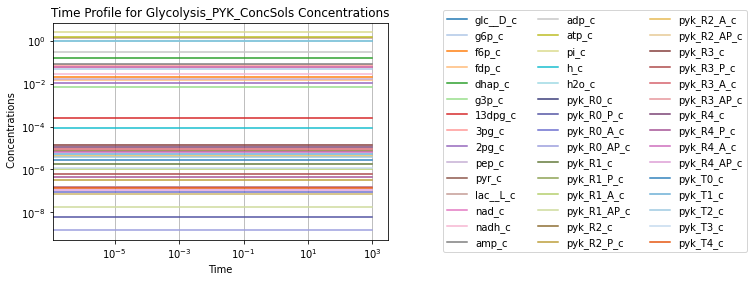

In [21]:
# Setup simulation object, ensure model is at steady state
sim = Simulation(glycolysis_PYK, verbose=True)
sim.find_steady_state(glycolysis_PYK, strategy="simulate",
                      update_values=True, tfinal=1e4)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis_PYK,
                                  time=(0, 1e3, 1e4 + 1))
# Quickly render and display time profiles 
conc_sol.view_time_profile()

## Export

In [22]:
json.save_json_model(
    mass_model=PYK,
    filename=path.realpath(path.join("CS1_data", "models",  PYK.id + ".json")))